# Summary

First, I want to try out 4 different optimizers on the baseline model.


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig
    
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs
    
    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0) 
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch
    
    def __len__(self):
        return len(self.ebno_dbs)
        


In [3]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, 
                         Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)


# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)

In [4]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [5]:
class Simplemodel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [13]:
from tqdm.auto import tqdm

def training_loop(model, start_epoch, num_epochs, use_scheduler=False, verbose=True):
    model=model.to(device)

    train_losses = []
    val_losses = []
    val_BERs = []
    for epoch in range(start_epoch, num_epochs):
        total_loss = 0.0
        model.train()  # Set the model to training mode

        for index, data_batch in enumerate(tqdm(train_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            outputs = model(samples)  # forward pass 
            loss = loss_fn(outputs, labels) 
            loss.backward()  # backward pass
            optimizer.step()  # update the weights
            total_loss += loss.item()  # accumulate the loss
            optimizer.zero_grad()  # Zero the gradients
        
        if use_scheduler:
            scheduler.step()
        # Print average loss for the epoch
        average_loss = total_loss / len(train_loader)
    
        # Validation
        model.eval()  # Set the model to evaluation mode
        BER_batch=[]
        with torch.no_grad():
            for index, data_batch in enumerate(tqdm(val_loader)):
                batch = {k: v.to(device) for k, v in data_batch.items()}
                samples = batch['samples']
                labels = batch['labels']
                val_outputs = model(samples)
                val_loss = loss_fn(val_outputs, labels)
    
                # Convert probabilities to binary predictions (0 or 1)
                binary_predictions = torch.round(val_outputs)
    
                # Calculate Bit Error Rate (BER)
                error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
                error_rate = error_count / len(labels.flatten())  # Error rate calculation
                BER_batch.append(error_rate.item())
                
        # Save performance details
        train_losses.append(average_loss)
        val_losses.append(val_loss.item())
        BER_batch_mean=np.mean(BER_batch)
        val_BERs.append(BER_batch_mean)#(BER.item())
    
        # Print or log validation loss after each epoch
        if verbose == True:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")
    return train_losses, val_losses, val_BERs

def save_model(model, model_name):
    # Save the final trained model
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }
    modelsave_path = os.path.join(trainoutput, model_name)
    torch.save(checkpoint, modelsave_path)

def plot_train_val_loss(train_losses, val_losses, name="test"):
    # Plot Training Loss and Validation Loss
    plt.figure(figsize=(7, 3))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.grid(True)
    plt.savefig(f"./graphs/{name}.pdf", format='pdf', bbox_inches='tight')

def plot_val_BER(val_BERs, name="test"):
    # Plot Validation BER
    plt.figure(figsize=(7, 3))
    plt.plot(val_BERs, label='Validation BER')
    plt.xlabel('Epochs')
    plt.ylabel('BER')
    plt.legend()
    plt.title('Bit Error Rate (BER) on validation set')
    plt.grid(True)
    plt.savefig(f"./graphs/{name}.pdf", format='pdf', bbox_inches='tight')

In [70]:
# Create model
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizers = [torch.optim.Adam, torch.optim.NAdam, torch.optim.RMSprop]

In [71]:
avg_train = []
avg_val = []
avg_BERs = []
for optimizer in optimizers:
    # Create model
    model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
    optimizer = optimizer(model.parameters())
    # Setup loss + optimizer
    loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
    
    train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, verbose=False)
    avg_train.append(np.mean(train_losses))
    avg_val.append(np.mean(val_losses))
    avg_BERs.append(np.mean(val_BERs))
    

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 351.83it/s]


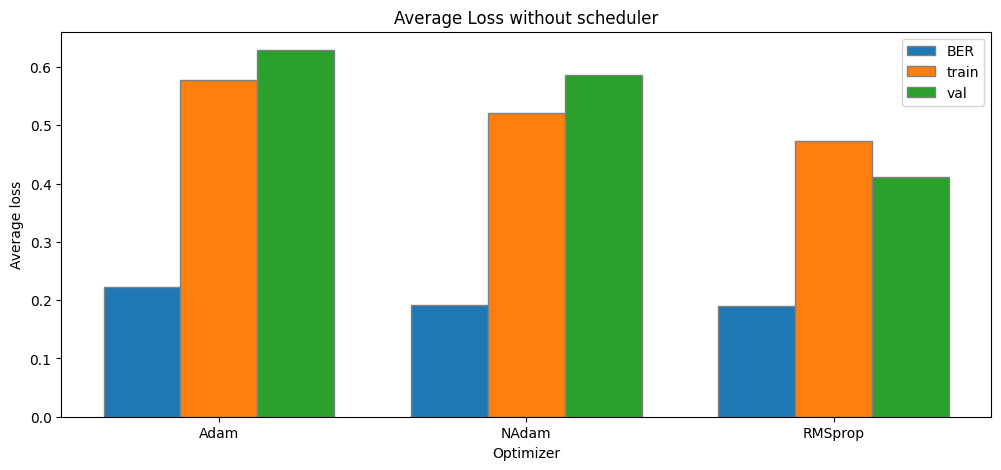

In [75]:
import seaborn as sns
import pandas as pd
plt.figure(figsize=(12, 5))

bar_width = 0.25
br1 = np.arange(3)
br2 = [x + bar_width for x in br1]
br3 = [x + bar_width for x in br2]

plt.bar(br1, avg_BERs, label='BER', edgecolor='grey',width=bar_width)
plt.bar(br2, avg_train, label='train', edgecolor='grey', width=bar_width)
plt.bar(br3, avg_val, label='val', edgecolor='grey', width=bar_width)

plt.xticks([r + bar_width for r in range(3)],
           ['Adam', 'NAdam', 'RMSprop'])
plt.xlabel('Optimizer')
plt.ylabel('Average loss')
plt.title("Average Loss without scheduler")
plt.legend()
plt.savefig("./average_loss_optimizers.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [76]:
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
optimizer = torch.optim.NAdam(model.parameters())

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

NAdam_train, NAdam_val, NAdam_BER, = training_loop(model, 0, 10, use_scheduler=True, verbose=False) 

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 329.23it/s]


In [83]:

model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
optimizer = torch.optim.RMSprop(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

RMSProp_train, RMSProp_val, RMSProp_BER, = training_loop(model, 0, 10, use_scheduler=True, verbose=False)    

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 324.58it/s]


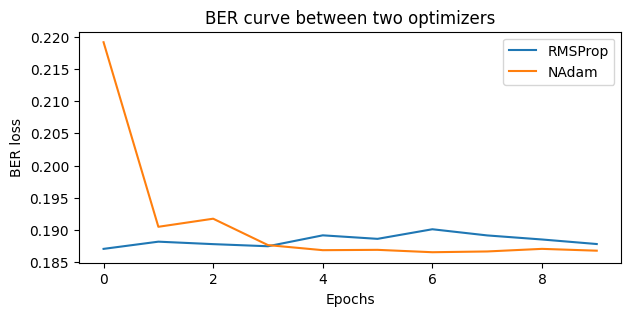

In [85]:
plt.figure(figsize=(7, 3))
plt.plot(RMSProp_BER, label='RMSProp')
plt.plot(NAdam_BER, label='NAdam')
plt.ylabel('BER loss')
plt.xlabel('Epochs')
plt.title('BER curve between two optimizers')
plt.legend()
plt.savefig('BER_curve_btw_two_optim.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [86]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [89]:
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

NAdam_norm_train, NAdam_norm_val, NAdam_norm_BER, = training_loop(model, 0, 10, use_scheduler=True, verbose=False) 

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 345.69it/s]


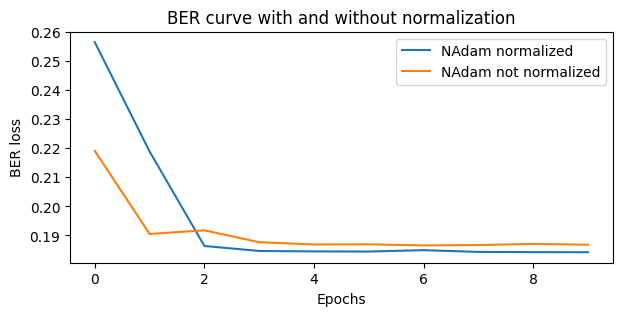

In [90]:
plt.figure(figsize=(7, 3))
plt.plot(NAdam_norm_BER, label='NAdam normalized')
plt.plot(NAdam_BER, label='NAdam not normalized')
plt.ylabel('BER loss')
plt.xlabel('Epochs')
plt.title('BER curve with and without normalization')
plt.legend()
plt.savefig('BER_curve_normalization.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [95]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=128)
        self.linear2=nn.Linear(in_features=128, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [96]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [98]:
NAdam_more_n_train, NAdam_more_n_val, NAdam_more_n_BER = training_loop(model, 0, 10, use_scheduler=True)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 345.79it/s]


Epoch [1/10], Loss: 0.5631, Val Loss: 0.5396, Val BER: 0.1947


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 334.91it/s]


Epoch [2/10], Loss: 0.4848, Val Loss: 0.4416, Val BER: 0.1846


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.83it/s]


Epoch [3/10], Loss: 0.4650, Val Loss: 0.9013, Val BER: 0.1852


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 337.79it/s]


Epoch [4/10], Loss: 0.4599, Val Loss: 0.8822, Val BER: 0.1843


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 346.13it/s]


Epoch [5/10], Loss: 0.4568, Val Loss: 0.7797, Val BER: 0.1841


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 343.22it/s]


Epoch [6/10], Loss: 0.4539, Val Loss: 0.4285, Val BER: 0.1841


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 354.06it/s]


Epoch [7/10], Loss: 0.4520, Val Loss: 0.9124, Val BER: 0.1843


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 337.41it/s]


Epoch [8/10], Loss: 0.4497, Val Loss: 0.4969, Val BER: 0.1843


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 368.89it/s]


Epoch [9/10], Loss: 0.4484, Val Loss: 0.3756, Val BER: 0.1842


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 340.87it/s]

Epoch [10/10], Loss: 0.4475, Val Loss: 0.6852, Val BER: 0.1842


In [99]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=256)
        self.linear2=nn.Linear(in_features=256, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

NAdam_256n_train, NAdam_256n_val, NAdam_256n_BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 355.39it/s]


In [100]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=64)
        self.linear2=nn.Linear(in_features=64, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

NAdam_64n_train, NAdam_64n_val, NAdam_64n_BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 333.44it/s]


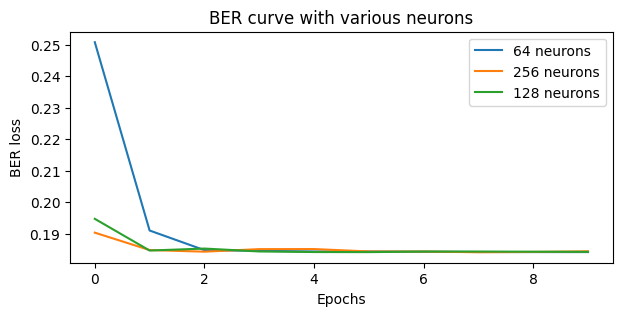

In [101]:
plt.figure(figsize=(7, 3))
plt.plot(NAdam_64n_BER, label='64 neurons')
plt.plot(NAdam_256n_BER, label='256 neurons')
plt.plot(NAdam_more_n_BER, label='128 neurons')
plt.ylabel('BER loss')
plt.xlabel('Epochs')
plt.title('BER curve with various neurons')
plt.legend()
plt.savefig('BER_curve_neurons.pdf', format='pdf', bbox_inches='tight')
plt.show()

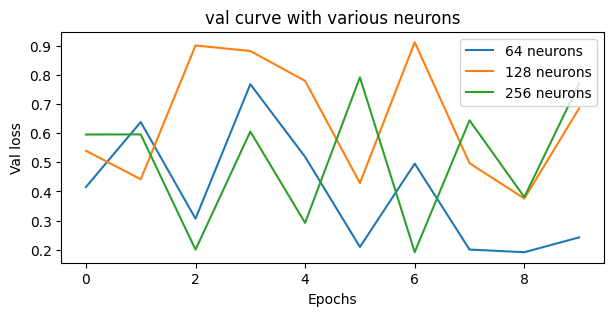

In [104]:
plt.figure(figsize=(7, 3))
plt.plot(NAdam_64n_val, label='64 neurons')
plt.plot(NAdam_more_n_val, label='128 neurons')
plt.plot(NAdam_256n_val, label='256 neurons')
plt.ylabel('Val loss')
plt.xlabel('Epochs')
plt.title('val curve with various neurons')
plt.legend()
plt.savefig('val_curve_neurons.pdf', format='pdf', bbox_inches='tight')
plt.show()

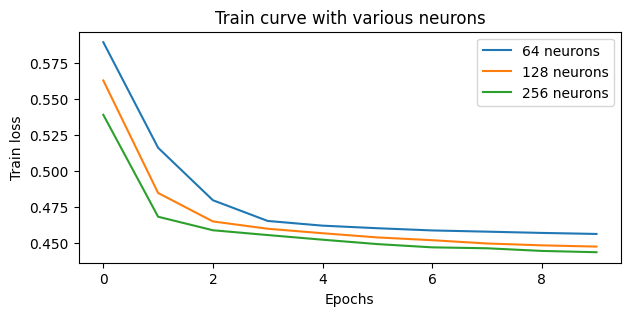

In [105]:
plt.figure(figsize=(7, 3))
plt.plot(NAdam_64n_train, label='64 neurons')
plt.plot(NAdam_more_n_train, label='128 neurons')
plt.plot(NAdam_256n_train, label='256 neurons')
plt.ylabel('Train loss')
plt.xlabel('Epochs')
plt.title('Train curve with various neurons')
plt.legend()
plt.savefig('Train_curve_neurons.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [107]:
## 2 layers
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(in_features=128, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

NAdam_128n_128n_train, NAdam_128n_128n_val, NAdam_128n_128n_BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 361.89it/s]


In [108]:
## 2 layers
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(in_features=32, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

NAdam_64n_32n_train, NAdam_64n_32n_val, NAdam_64n_32n_BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 327.48it/s]


In [109]:
## 2 layers
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(in_features=16, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

NAdam_32n_16n_train, NAdam_32n_16n_val, NAdam_32n_16n_BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 342.64it/s]


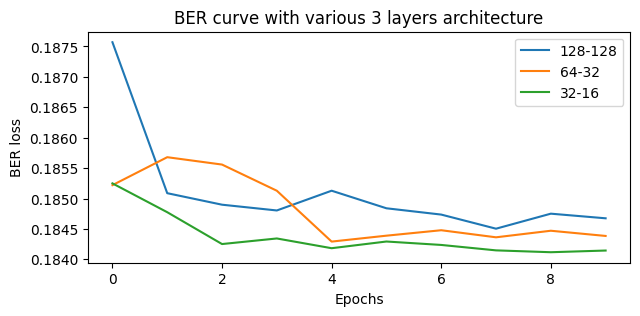

In [111]:
plt.figure(figsize=(7, 3))
plt.plot(NAdam_128n_128n_BER, label='128-128')
plt.plot(NAdam_64n_32n_BER, label='64-32')
plt.plot(NAdam_32n_16n_BER, label='32-16')
plt.ylabel('BER loss')
plt.xlabel('Epochs')
plt.title('BER curve with various 3 layers architecture')
plt.legend()
plt.savefig('BER_curve_3l.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [112]:
class SimpleConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = 8
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=6, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(6, 16, 3, padding='same')
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 4)
        self.activation = nn.ReLU()
        
    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 0, 2, 3) # batch channels x y
        z = torch.nn.functional.normalize(z)
        z = self.activation(self.conv1(z))
        z = self.activation(self.conv2(z))
        z = z.permute(0, 2, 3, 1)
        z = self.activation(self.fc1(z))
        z = self.fc2(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

# Create model
model = SimpleConv()

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

conv_train, conv_val, conv_BERs, = training_loop(model, 0, 10, use_scheduler=True, verbose=False)


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 355.41it/s]


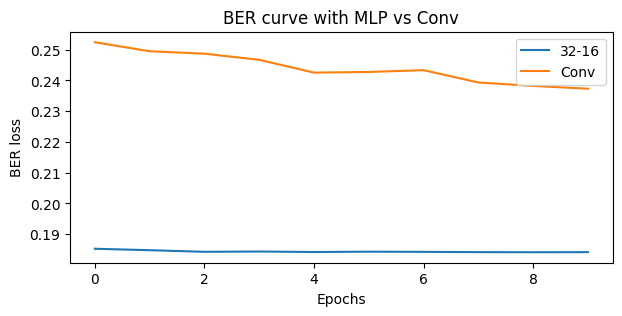

In [121]:
plt.figure(figsize=(7, 3))
plt.plot(NAdam_32n_16n_BER, label='32-16')
plt.plot(conv_BERs, label='Conv')
plt.ylabel('BER loss')
plt.xlabel('Epochs')
plt.title('BER curve with MLP vs Conv')
plt.legend()
plt.savefig('BER_curve_conv.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [115]:
np.mean(NAdam_64n_32n_BER)

0.1847964262962341

In [117]:
np.mean(NAdam_more_n_BER)

0.18539862632751464

In [120]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(in_features=16, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.dropout(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.dropout(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

NAdam_32n_16n_dropout_train, NAdam_32n_16n_dropout_val, NAdam_32n_16n_dropout_BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 320.81it/s]


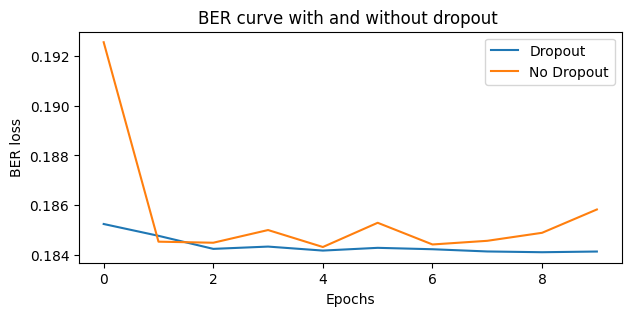

In [125]:
plt.figure(figsize=(7, 3))
plt.plot(NAdam_32n_16n_BER, label='Dropout')
plt.plot(NAdam_32n_16n_dropout_BER, label='No Dropout')
plt.ylabel('BER loss')
plt.xlabel('Epochs')
plt.title('BER curve with and without dropout ')
plt.legend()
plt.savefig('BER_curve_dropout.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [127]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -30
DB_MAX = 30

dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, 
                         Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)


# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

high_db_range_train, high_db_range_val,high_db_range__BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.91it/s]


In [128]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -10
DB_MAX = 10

dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, 
                         Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)


# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

low_db_range_train, low_db_range_val, low_db_range__BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 331.32it/s]


In [129]:
NUM_BITS_PER_SYMBOL = 2
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -10
DB_MAX = 10

dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, 
                         Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)


# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

bit2_train, bit2_val, bit2_BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 232.79it/s]


In [130]:
NUM_BITS_PER_SYMBOL = 8
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -10
DB_MAX = 10

dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, 
                         Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)


# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)

# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

bit8_train, bit8_val, bit8_BER = training_loop(model, 0, 10, use_scheduler=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 428.47it/s]


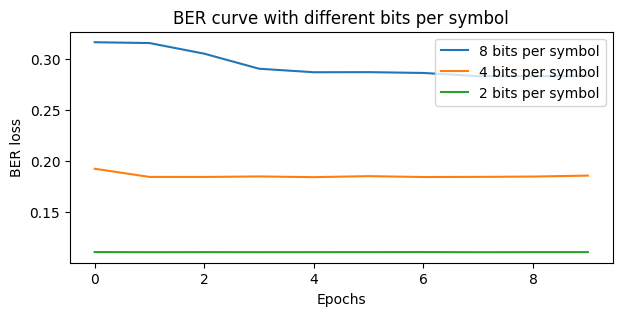

In [131]:
plt.figure(figsize=(7, 3))
plt.plot(bit8_BER, label='8 bits per symbol')
plt.plot(NAdam_32n_16n_dropout_BER, label='4 bits per symbol')
plt.plot(bit2_BER, label='2 bits per symbol')
plt.ylabel('BER loss')
plt.xlabel('Epochs')
plt.title('BER curve with different bits per symbol')
plt.legend()
plt.savefig('BER_curve_bits.pdf', format='pdf', bbox_inches='tight')
plt.show()

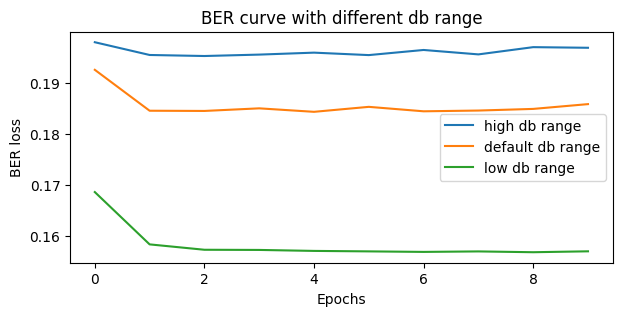

In [132]:
plt.figure(figsize=(7, 3))
plt.plot(high_db_range__BER, label='high db range')
plt.plot(NAdam_32n_16n_dropout_BER, label='default db range')
plt.plot(low_db_range__BER, label='low db range')
plt.ylabel('BER loss')
plt.xlabel('Epochs')
plt.title('BER curve with different db range')
plt.legend()
plt.savefig('BER_curve_range.pdf', format='pdf', bbox_inches='tight')
plt.show()